### Intro to Quantum Programming - Spring 2021
## Homework 3: Due 03/12/2021

For each exercise below, add as many cells as you want. To evaluate your submission, I will do **Restart and Run All**. . For help with Markdown, see [this link](https://www.markdownguide.org/).

In [1]:
# Here's a cell for import statements... add more if necessary (or just import below as needed)
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, AncillaRegister
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library.standard_gates import XGate, CZGate, CXGate, SGate, CPhaseGate, PhaseGate
from qiskit.circuit.library import GroverOperator, QFT
import numpy as np
cXGate = XGate().control(7)

For this assignment you can use the [GroverOperator](https://qiskit.org/documentation/stubs/qiskit.circuit.library.GroverOperator.html) and [QFT](https://qiskit.org/documentation/stubs/qiskit.circuit.library.QFT.html) circuits provided by the Qiskit Circuit Library. You can also use other logic circuits provided by the [library](https://qiskit.org/documentation/apidoc/circuit_library.html).

----
#### Exercise 3.1

In games like *Candy Crush* or *Bejeweled*, the player tries to swap pieces to make three in a row, either horizontally or vertically. For this exercise, use the Grover search algorithm to determine whether a single swap between two rows will create a match. (We will only consider swapping between two rows to create a horizontal match.)

We will have only two kinds of items -- red balls (1) and blue balls (0). There will be two rows of three balls, each represented by a binary value.  For example, here is a row of Blue, Blue, Red on top, and Red, Red, Blue on bottom:
```
001
110
```
For this example, swapping the balls on the right, will result in a match on both the top and bottom rows.

For some arrangements, there are two possible swaps.  For example, swapping on the right or the left will result in a match.
```
011
110
```

If the two rows are the same, then no swap will work:
```
110
110
```

You may assume that a configuration that already contains a match (000 or 111) will not be entered.

Create a quantum circuit that finds either one or two moves, given an initial configuration of the two rows. Your circuit must use 6 qubits to represent the row state, and the `rowPrep` function below is given to simplify the preparation of those qubits. You can change the `rowPrep` code as needed (e.g., to initialize qubits in a way that fits your circuit), but the interface must remain the same.

Your circuit must use Grover's algorithm to find a solution, or find that there is no solution.

Use the QASM simulator to demonstrate your circuit. Your demonstration code must interpret the results and print a solution, if there is one, or say that there is no solution. (In other words, the interpretation of your result must be automated, so that a clear answer is presented to the reader -- don't just print a histogram and have the reader figure it out.) 

Make sure the initialization procedure for your demonstration is clear, as well as the procedure to run the demo. I will want to test with multiple row configurations.

In [2]:
# arguments are two three-char strings with '1' and '0'
# first argument is top row (e.g., '110') and second is bottom row (e.g., '001')
# initialization has top row in lowest three bits, bottom in highest three (e.g., 001110)
def rowPrep(top, bottom):
    sv = Statevector.from_label(bottom+top)
    qc = QuantumCircuit(6, name='prep')
    qc.initialize(sv.data, list(range(0,6)))
    return qc

Now, to generate the gates to test each situation.

The next two functions are used internally to generate the string for the control x gates to be used later

In [3]:
# Generates string for the control x if its testing the top bit
def stringTop(listState, state, move, k):
    listForGate = []
    for i in range(3):
        listForGate.append(state[i])
        if i not in listState:
            antiControl = i
    for i in range(3,6):
        if i in listState:
            listForGate.append(state[i])
    for i in range(3):
        listForGate.append(move[i])
    listForGate.append(k[0])
    return listForGate

In [4]:
def stringBottom(listState, state, move, k):
    listForGate = []
    for i in range(3):
        if i in listState:
            listForGate.append(state[i])
    for i in range(3,6):
        listForGate.append(state[i])
        if i not in listState:
            antiControl = i
    for i in range(3):
        listForGate.append(move[i])
    listForGate.append(k[1])
    return listForGate

The next two functions create the circuits to be used internally later on to test each move

In [19]:
# Function to test the 'top' row for 1s and 'bottom' row for 0s

# qc is the quantum circuit, listState is the list used for the cXGate, moveNumber is to determine which 'move' is being 
# tested, isTop is whether the top or bottom is being tested

def topO(qc, listForGate, moveNumber, isTop):
    moveNumber2 = moveNumber
    if isTop == 0:
        moveNumber2 = moveNumber2 - 3

    qc.x(moveNumber)
    for i in range(3):
        if i != moveNumber2:
            qc.x(6+i)
    qc.append(cXGate, listForGate)
    for i in range(3):
        if i != moveNumber2:
            qc.x(6+i)
    qc.x(moveNumber)
    qc.barrier()
    
    

In [6]:
# Function to test the 'top' row for 0s and 'bottom' row for 1s

# qc is the quantum circuit, listState is the list used for the cXGate, moveNumber is to determine which 'move' is being 
# tested, listState is the list of gates to be used

def topZ(qc, listForGate, moveNumber, listState):
    for i in range(6):
        if i in listState:
            qc.x(i)
    
    for i in range(3):
        if i != moveNumber:
            qc.x(6+i)
    qc.append(cXGate, listForGate)
    for i in range(3):
        if i != moveNumber:
            qc.x(6+i)
            
    for i in range(6):
        if i in listState:
            qc.x(i)
            
    qc.barrier()

The next functions test every move, and apply a z gate if it wins the game

In [20]:
# Tests the first move for the top row for 1s, or the first move for the bottom row for 0s

def firstO(state,move):
    k = AncillaRegister(2, 'k')
    qc = QuantumCircuit(state,move,k)
    
    listState = [1,2,3]
    listForGate = stringTop(listState, state, move, k)
    listStateB = [0,4,5]
    listForGateB = stringBottom(listStateB, state, move, k)
    
#     Top
    topO(qc, listForGate, 0, 1)
    
#     Bottom
    topZ(qc, listForGateB, 0, listStateB)
    
#     Zs
    qc.z(9)
    qc.cz(9,10)
    qc.z(10)
    qc.barrier()

#     Bottom
    topZ(qc, listForGateB, 0, listStateB)
    
#     Top
    topO(qc, listForGate, 0, 1)
        
    return qc

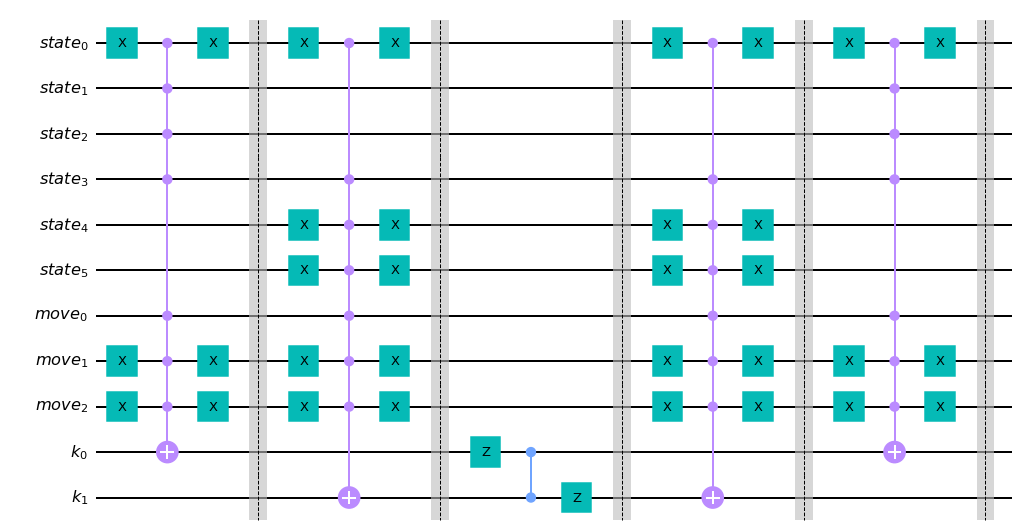

In [8]:
# Visualization for first0

a = QuantumRegister(6, 'state')
b = QuantumRegister(3, 'move')

firstO(a, b).draw('mpl')


In [21]:
# Tests the first move for the top row for 0s, or the first move for the bottom row for 1s

def firstZ(state,move):
    k = AncillaRegister(2, 'k')
    qc = QuantumCircuit(state,move,k)
    
    listState = [1,2,3]
    listForGate = stringTop(listState, state, move, k)
    listStateB = [0,4,5]
    listForGateB = stringBottom(listStateB, state, move, k)
    
#     Top
    topZ(qc, listForGate, 0, listState)
    
#     Bottom
    topO(qc, listForGateB, 3, 0)
    
#     Zs
    qc.z(9)
    qc.cz(9,10)
    qc.z(10)
    qc.barrier()
    
#     Bottom
    topO(qc, listForGateB, 3, 0)
    
#     Top
    topZ(qc, listForGate, 0, listState)
        
    return qc

[Qubit(QuantumRegister(6, 'state'), 0), Qubit(QuantumRegister(6, 'state'), 3), Qubit(QuantumRegister(6, 'state'), 4), Qubit(QuantumRegister(6, 'state'), 5), Qubit(QuantumRegister(3, 'move'), 0), Qubit(QuantumRegister(3, 'move'), 1), Qubit(QuantumRegister(3, 'move'), 2), AncillaQubit(AncillaRegister(2, 'k'), 1)]
[Qubit(QuantumRegister(6, 'state'), 0), Qubit(QuantumRegister(6, 'state'), 3), Qubit(QuantumRegister(6, 'state'), 4), Qubit(QuantumRegister(6, 'state'), 5), Qubit(QuantumRegister(3, 'move'), 0), Qubit(QuantumRegister(3, 'move'), 1), Qubit(QuantumRegister(3, 'move'), 2), AncillaQubit(AncillaRegister(2, 'k'), 1)]


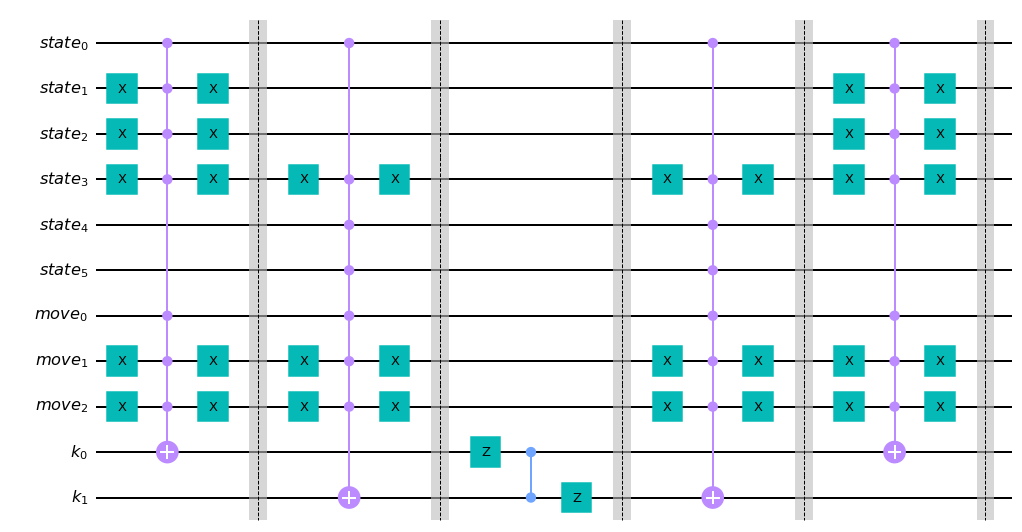

In [22]:
# Visualization for firstZ

a = QuantumRegister(6, 'state')
b = QuantumRegister(3, 'move')

firstZ(a, b).draw('mpl')


In [11]:
# Tests the second move for the top row for 1s, or the second move for the bottom row for 0s

def secondO(state,move):
    k = AncillaRegister(2, 'k')
    qc = QuantumCircuit(state,move,k)
    
    listState = [0,2,4]
    listForGate = stringTop(listState, state, move, k)
    listStateB = [1,3,5]
    listForGateB = stringBottom(listStateB, state, move, k)
    
#     Top
    topO(qc, listForGate, 1, 1)

#     Bottom
    topZ(qc, listForGateB, 1, listStateB)
    
#     Zs
    qc.z(9)
    qc.cz(9,10)
    qc.z(10)
    qc.barrier()

#     Bottom
    topZ(qc, listForGateB, 1, listStateB)
    
#     Top
    topO(qc, listForGate, 1, 1)
        
    return qc


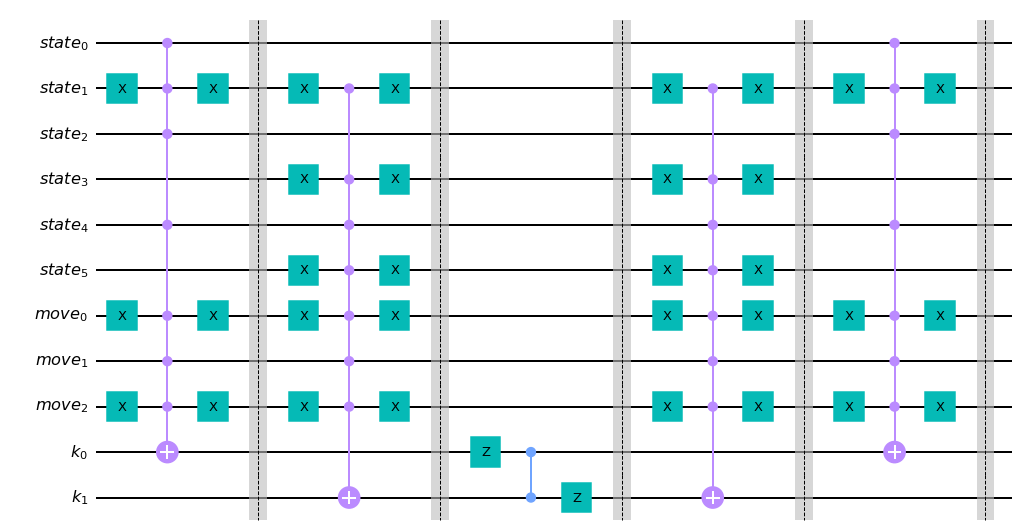

In [12]:
# Visualization for secondO

a = QuantumRegister(6, 'state')
b = QuantumRegister(3, 'move')

secondO(a, b).draw('mpl')


In [13]:
# Tests the second move for the top row for 0s, or the second move for the bottom row for 1s

def secondZ(state,move):
    k = AncillaRegister(2, 'k')
    qc = QuantumCircuit(state,move,k)
    
    listState = [0,2,4]
    listForGate = stringTop(listState, state, move, k)
    listStateB = [1,3,5]
    listForGateB = stringBottom(listStateB, state, move, k)
    
#     Top
    topZ(qc, listForGate, 1, listState)
    
#     Bottom
    topO(qc, listForGateB, 4, 0)
    
#     Zs
    qc.z(9)
    qc.cz(9,10)
    qc.z(10)
    qc.barrier()
    
#     Bottom
    topO(qc, listForGateB, 4, 0)
    
#     Top
    topZ(qc, listForGate, 1, listState)
        
    return qc


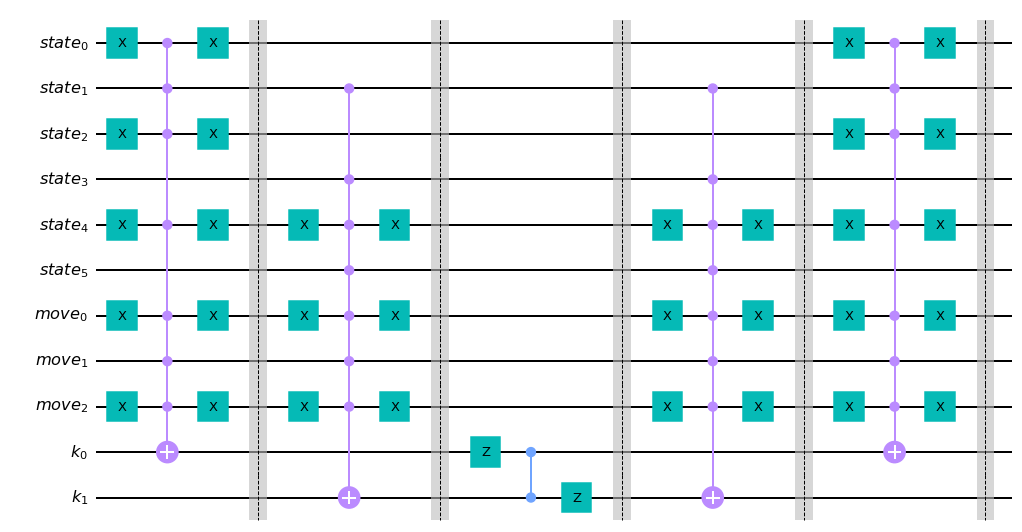

In [14]:
# Visualization for secondZ

a = QuantumRegister(6, 'state')
b = QuantumRegister(3, 'move')

secondZ(a, b).draw('mpl')


In [15]:
# Tests the third move for the top row for 1s, or the third move for the bottom row for 0s

def thirdO(state,move):
    k = AncillaRegister(2, 'k')
    qc = QuantumCircuit(state,move,k)
    
    listState = [0,1,5]
    listForGate = stringTop(listState, state, move, k)
    listStateB = [2,3,4]
    listForGateB = stringBottom(listStateB, state, move, k)
    
#     Top
    topO(qc, listForGate, 2, 1)

#     Bottom
    topZ(qc, listForGateB, 2, listStateB)
    
#     Zs
    qc.z(9)
    qc.cz(9,10)
    qc.z(10)
    qc.barrier()

#     Bottom
    topZ(qc, listForGateB, 2, listStateB)
    
#     Top
    topO(qc, listForGate, 2, 1)
        
    return qc


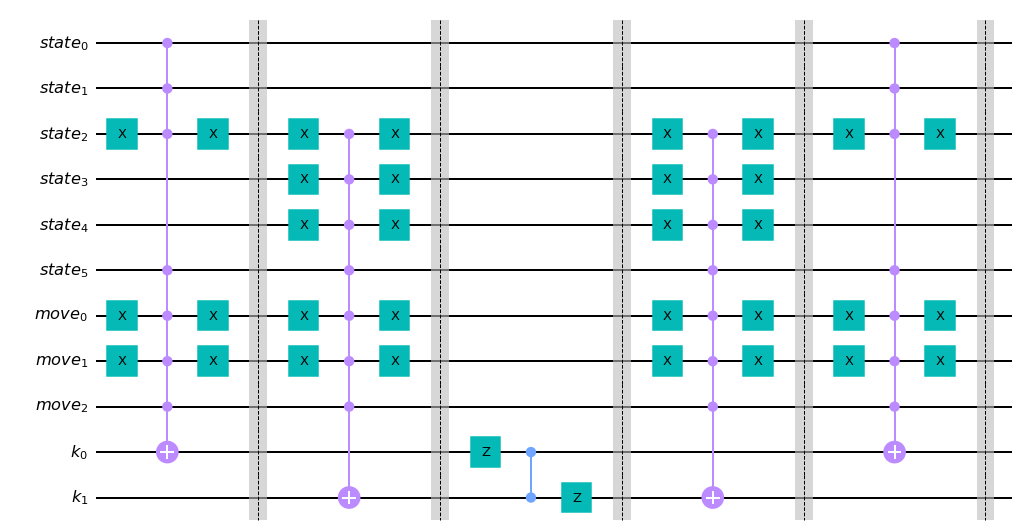

In [16]:
# Visualization for third0

a = QuantumRegister(6, 'state')
b = QuantumRegister(3, 'move')

thirdO(a, b).draw('mpl')


In [17]:
# Tests the third move for the top row for 0s, or the third move for the bottom row for 1s

def thirdZ(state,move):
    k = AncillaRegister(2, 'k')
    qc = QuantumCircuit(state,move,k)
    
    listState = [0,1,5]
    listForGate = stringTop(listState, state, move, k)
    listStateB = [2,3,4]
    listForGateB = stringBottom(listStateB, state, move, k)
    
#     Top
    topZ(qc, listForGate, 2, listState)
    
#     Bottom
    topO(qc, listForGateB, 5, 0)
    
#     Zs
    qc.z(9)
    qc.cz(9,10)
    qc.z(10)
    qc.barrier()
    
#     Bottom
    topO(qc, listForGateB, 5, 0)
    
#     Top
    topZ(qc, listForGate, 2, listState)
        
    return qc

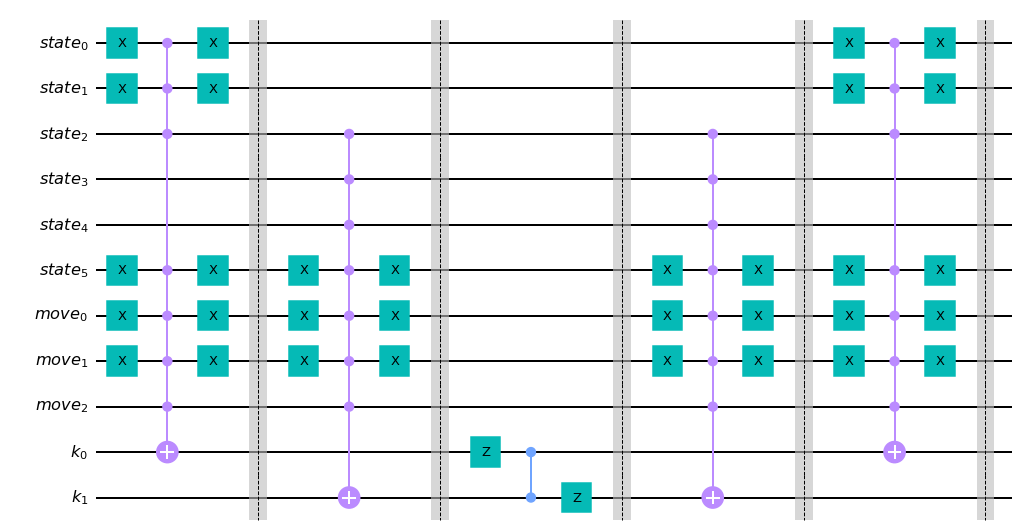

In [18]:
# Visualization for thirdZ

a = QuantumRegister(6, 'state')
b = QuantumRegister(3, 'move')

thirdZ(a, b).draw('mpl')


Next, the oracle is created using these internal functions defined above to test every move, and mark the correct move for the grover algorithm

In [19]:
# Oracle to be used

def oracle():
    a = QuantumRegister(6, 'state')
    b = QuantumRegister(3, 'move')
    x = QuantumRegister(2, 'ancilla')
    oc = QuantumCircuit(a,b,x)
    oc.append(firstO(a,b),a[:]+b[:]+x[:])
    oc.append(firstZ(a,b),a[:]+b[:]+x[:])
    oc.append(secondO(a,b),a[:]+b[:]+x[:])
    oc.append(secondZ(a,b),a[:]+b[:]+x[:])
    oc.append(thirdO(a,b),a[:]+b[:]+x[:])
    oc.append(thirdZ(a,b),a[:]+b[:]+x[:])
    return oc

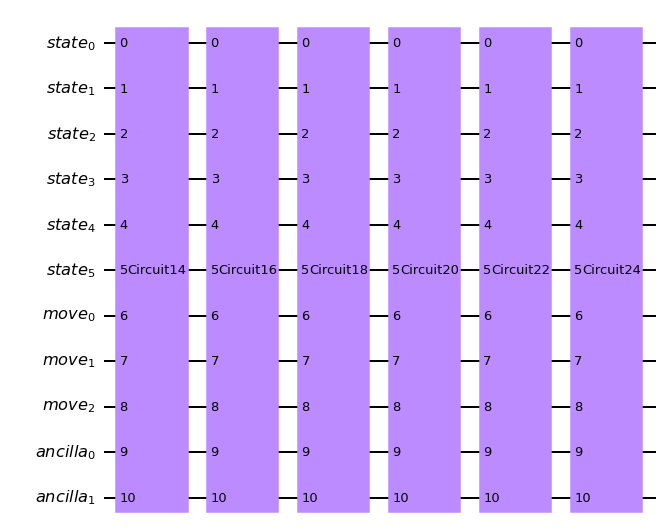

In [20]:
# Oracle visualized
oracle().draw('mpl')

Now, to test this function using Grover Search.

The next function uses Grover Search to find the next move, and outputs it into a nice, easily digestible answer on whether the move works or not

In [41]:
# Function that searches and outputs what move to do, or that there isn't a move

# Top is the top row to be initalized
# Bottom is the bottom row to be initalized
def search(top, bottom):
#     Initialize the state register
    state = QuantumRegister(6, 'state')
    qc = QuantumCircuit(state) 
    qc.append(rowPrep(top, bottom),state[:])
    
#     Initialize the move register into + state
    move = QuantumRegister(3, 'move')
    qc.add_register(move)
    qc.h(move)

#     Initialize the result register (classical register to get answer)
    result = ClassicalRegister(3,'result')
    qc.add_register(result)
    
#     Initialize the two ancilla bits necessary
    anc = QuantumRegister(2, 'ancilla') 
    qc.add_register(anc)
    
#     Run the grover operator
    qc.append(GroverOperator(oracle(), reflection_qubits=[6,7,8]), state[:]+move[:]+anc[:])
    
#     Measure
    qc.measure(move, result)
    sim = Aer.get_backend('qasm_simulator')
    counts = execute(qc, sim).result().get_counts()
    
    
#     Post processing to make the output easier
    move1 = 0
    move2 = 0
    move3 = 0
    
    if (counts.get('100') is not None and counts.get('100') >= 0.4 * 1024):
        move1 = 1
    if (counts.get('010') is not None and counts.get('010') >= 0.4 * 1024):
        move2 = 1
    if (counts.get('001') is not None and counts.get('001') >= 0.4 * 1024):
        move3 = 1
        
    if move1 == 1:
        print('Swapping the balls on the left works')        
    if move2 == 1:
        print('Swapping the middle balls works')        
    if move3 == 1:
        print('Swapping the balls on the right works')
    if ((move1 == 0) and (move2 == 0) and (move3 == 0)):
        print('No Moves Work')

Examples of the code working / searching 

In [42]:
# Test 001 110
# Expected output should be swapping the balls on the right
print("Testing: 001 / 110")
print("Expected:\nSwapping the balls on the right works\n")
print("Actual:")

# Change this search value to change the test
search('110', '001')

Testing: 001 / 110
Expected:
Swapping the balls on the right works

Actual:
Swapping the balls on the right works


In [43]:
# Test 010 101
# Expected output should be swapping the balls in the middle
print("Testing: 010 / 101")
print("Expected:\nSwapping the middle balls works\n")
print("Actual:")

# Change this search value to change the test
search('101', '010')

Testing: 010 / 101
Expected:
Swapping the middle balls works

Actual:
Swapping the middle balls works


In [24]:
# Test 100 011
# Expected output should be swapping the balls on the left
print("Testing: 011 / 100")
print("Expected:\nSwapping the balls on the left works\n")
print("Actual:")

# Change this search value to change the test
search('011', '100')

Testing: 011 / 100
Expected:
Swapping the balls on the left works

Actual:
Swapping the balls on the left works


In [48]:
# Test 011 110
# Expected output should be swapping the balls on the right or the left
print("Testing: 011 / 110")
print("Expected:\nSwapping the balls on the left works")
print("Swapping the balls on the right works\n")
print("Actual:")

# Change this search value to change the test
search('110', '011')

Testing: 011 / 110
Expected:
Swapping the balls on the left works
Swapping the balls on the right works

Actual:
Swapping the balls on the left works
Swapping the balls on the right works


In [26]:
# Test 110 110
# Expected output should be swapping the balls on the right or the left
print("Testing: 110 / 110")
print("Expected:\nNo Moves Work\n")
print("Actual:")
search('110', '110')

Testing: 110 / 110
Expected:
No Moves Work

Actual:
No Moves Work


To run your own test, change the initial values to the search function below:


In [27]:
# To run your own test, change the initial values to the search function below:
search('110', '110')

No Moves Work


----
#### Exercise 3.2

Use the Qiskit ``QFT`` circuit to generate the same state prepared by Example 7-5 in the textbook. Do not directly implement the gates in Figure 7-21 or Figure 7-25; you must use the ``QFT`` circuit. Clearly demonstrate that the proper state is being generated.

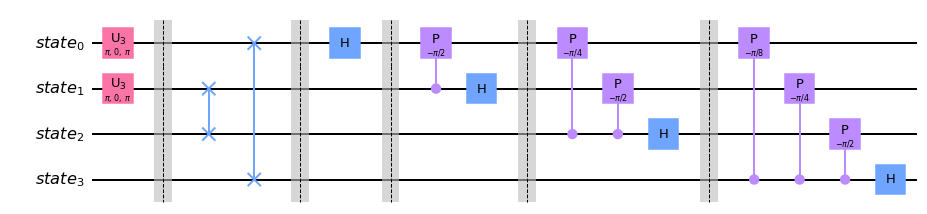

In [28]:
# Recreating Ex 7-5 using the Qiskit QFT

state = QuantumRegister(4, 'state')
qc = QuantumCircuit(state)
qc.x(0)
qc.x(1)
qc.barrier()
qc.append(QFT(4, insert_barriers=True, inverse=True), reversed(state[:]))


qc.decompose().draw('mpl')

In [29]:
# Outputing the statevector
v = Statevector.from_instruction(qc)
print(np.round(v.data[:16], 3))

[ 0.25 +0.j     0.096-0.231j -0.177-0.177j -0.231+0.096j -0.   +0.25j
  0.231+0.096j  0.177-0.177j -0.096-0.231j -0.25 +0.j    -0.096+0.231j
  0.177+0.177j  0.231-0.096j  0.   -0.25j  -0.231-0.096j -0.177+0.177j
  0.096+0.231j]


Explanation: The relative phase should oscillate three times across the register. This would mean that there should be slightly more than 5 states between each rotation (5.33, to be exact). We can verify that this by seeing that that state |5> is closer to state |0> than either state |4> or |5>, and seeing that state |11> is closer to state |0> than either state |10> or |12>

In [30]:
print("|" + str(0) + ">:\t", end='')
print(np.round(v.data[0],2), end='\n\n')

for i in [4, 5, 6]:
    print("|" + str(i) + ">:\t", end='')
    print(np.round(v.data[i],2), end='\n')
print('\n')
for i in [10, 11, 12]:
    print("|" + str(i) + ">:\t", end='')
    print(np.round(v.data[i],2), end='\n')

|0>:	(0.25+0j)

|4>:	(-0+0.25j)
|5>:	(0.23+0.1j)
|6>:	(0.18-0.18j)


|10>:	(0.18+0.18j)
|11>:	(0.23-0.1j)
|12>:	-0.25j


We can also see this with the state -0.25+0j. This should occur every 5.33 rotates starting at 2.67. Therefore, we should see that |3> is closer to it then either |2> or |4>. We should also see that |8> should be extremely close to it (as 2.67 + 5.33 = 8), and that |13> is closer than either |12> or |14>

In [31]:
for i in [2, 3, 4]:
    print("|" + str(i) + ">:\t", end='')
    print(np.round(v.data[i],2), end='\n')
print('\n')
for i in [8]:
    print("|" + str(i) + ">:\t", end='')
    print(np.round(v.data[i],2), end='\n')
print('\n')
for i in [12, 13, 14]:
    print("|" + str(i) + ">:\t", end='')
    print(np.round(v.data[i],2), end='\n')

|2>:	(-0.18-0.18j)
|3>:	(-0.23+0.1j)
|4>:	(-0+0.25j)


|8>:	(-0.25+0j)


|12>:	-0.25j
|13>:	(-0.23-0.1j)
|14>:	(-0.18+0.18j)


We should also see that every state should be close in phase to the states 5 and 10 states later, but a little further apart from one another (because a rotation happens every 5.33 states)

In [32]:
for i in range(0, 5, 1):
    print("|" + str(i) + ">:\t", end='')
    print(np.round(v.data[i],2), end='\n')
    print("|" + str(i+5) + ">:\t", end='')
    print(np.round(v.data[i+5],2), end='\n')
    print("|" + str(i+10) + ">:\t", end='')
    print(np.round(v.data[i+10],2), end='\n\n')

|0>:	(0.25+0j)
|5>:	(0.23+0.1j)
|10>:	(0.18+0.18j)

|1>:	(0.1-0.23j)
|6>:	(0.18-0.18j)
|11>:	(0.23-0.1j)

|2>:	(-0.18-0.18j)
|7>:	(-0.1-0.23j)
|12>:	-0.25j

|3>:	(-0.23+0.1j)
|8>:	(-0.25+0j)
|13>:	(-0.23-0.1j)

|4>:	(-0+0.25j)
|9>:	(-0.1+0.23j)
|14>:	(-0.18+0.18j)



#### Exercise 3.3

Use the Qiskit ``QFT`` circuit to generate the same state prepared by Example 7-6 in the textbook. Do not directly implement the gates in Figure 7-22; you must use the ``QFT`` circuit. Clearly demonstrate that the proper state is being generated.

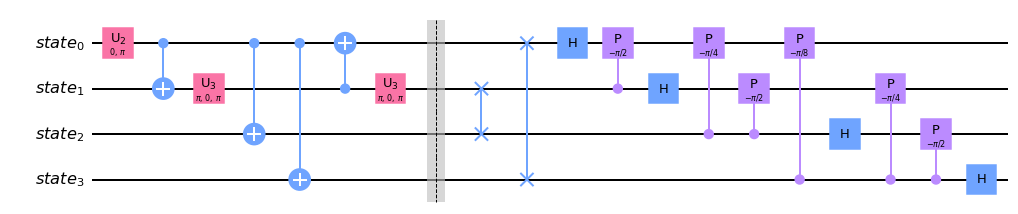

In [33]:
state = QuantumRegister(4, 'state')
qc = QuantumCircuit(state)
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
qc.cx(0,3)
qc.x(1)
qc.cx(1,0)
qc.x(1)
qc.barrier()
qc.append(QFT(4, inverse=True), reversed(state[:]))
qc.decompose().draw('mpl')

In [34]:
# Outputing the statevector
v = Statevector.from_instruction(qc)
print(np.round(v.data[:16], 3))

[ 0.354+0.j  0.327+0.j  0.25 +0.j  0.135+0.j  0.   -0.j -0.135-0.j
 -0.25 -0.j -0.327-0.j -0.354+0.j -0.327-0.j -0.25 -0.j -0.135-0.j
 -0.   +0.j  0.135+0.j  0.25 +0.j  0.327+0.j]


Explanation: This function should result in the states oscillating in magnitude to become smaller and smaller until they flip from positive to negative. Therefore, the sign should switch from + to - around state |4> and |12>.

In [35]:
for i in [3, 4, 5]:
    print("|" + str(i) + ">:\t", end='')
    print(np.round(v.data[i],2), end='\n')
print('\n')
for i in [11, 12, 13]:
    print("|" + str(i) + ">:\t", end='')
    print(np.round(v.data[i],2), end='\n')

|3>:	(0.14+0j)
|4>:	-0j
|5>:	(-0.14-0j)


|11>:	(-0.14-0j)
|12>:	(-0+0j)
|13>:	(0.14+0j)


Also, we should see that the absolute value of the magnitude of a state should be exactly the same as the state 8 away, as 16 / 2 = 8. We can see this by comparing them:

In [36]:
for i in range(0, 8, 1):
    print("|" + str(i) + ">:\t", end='')
    print(np.round(v.data[i],2), end='\n')
    print("|" + str(i+8) + ">:\t", end='')
    print(np.round(v.data[i+8],2), end='\n\n')

|0>:	(0.35+0j)
|8>:	(-0.35+0j)

|1>:	(0.33+0j)
|9>:	(-0.33-0j)

|2>:	(0.25+0j)
|10>:	(-0.25-0j)

|3>:	(0.14+0j)
|11>:	(-0.14-0j)

|4>:	-0j
|12>:	(-0+0j)

|5>:	(-0.14-0j)
|13>:	(0.14+0j)

|6>:	(-0.25-0j)
|14>:	(0.25+0j)

|7>:	(-0.33-0j)
|15>:	(0.33+0j)

